In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import math as m
import sympy as smp
from IPython.display import display as disp
import lablib as ll
%matplotlib inline

Пересчитаем значения давлений с приборов из мм. рт. ст. в паскали. Вычислим показания масляного разностного манометра, полученные при измерении объёма установки.

In [2]:
data, columns, experiments = ll.read_standard_layout()

# recalculate pressures in Torr (mmHg) to Pa
for e in experiments:
    for var in list(data[e].index) + list(columns[e].columns):
        if var.startswith("P_") and var != "P_atm":
            ll.compute(name = var,
                       expr = lambda _P: _P * ll.torr,
                       expr_args = [var],
                       data = data[e],
                       columns = columns[e])

# compute outputs from the oil column relative manometer
for e in ["volume"]:
    ll.compute(name = "dP_1",
               expr = lambda dH_1, de_oil: dH_1 * de_oil * ll.g,
               data = data[e])
    ll.compute(name = "dP_2",
               expr = lambda dH_2, de_oil: dH_2 * de_oil * ll.g,
               data = data[e])

for e in experiments:
    print("Experiment %s:" % e)
    disp(data[e])

Experiment leak:


,Value,Error,ErrorRel
V_locked,0.000050,0.000003,6.00%
P_atm,100000.000000,1000.000000,1.00%
de_oil,885.000000,0.500000,0.06%
g,9.806650,0.000005,0.00%
L_cap,0.063000,0.000500,0.79%
d_cap,0.000900,0.000050,5.56%
P_h_best,0.008933,0.000133,1.49%
P_h_leak,0.013332,0.001333,10.00%
P_f_leak,0.733273,0.033331,4.55%
T_ambient,300.000000,5.000000,1.67%


Experiment performance-fall:


,Value,Error,ErrorRel
V_locked,0.000050,0.000003,6.00%
P_atm,100000.000000,1000.000000,1.00%
de_oil,885.000000,0.500000,0.06%
g,9.806650,0.000005,0.00%
P_h_best,0.013332,0.001333,10.00%


Experiment performance-improve:


,Value,Error,ErrorRel
V_locked,0.000050,0.000003,6.00%
P_atm,100000.000000,1000.000000,1.00%
de_oil,885.000000,0.500000,0.06%
g,9.806650,0.000005,0.00%
P_h_best,0.013332,0.001333,10.00%


Experiment volume:


,Value,Error,ErrorRel
V_locked,0.000050,0.000003,6.00%
P_atm,100000.000000,1000.000000,1.00%
de_oil,885.000000,0.500000,0.06%
g,9.806650,0.000005,0.00%
P_f_best,1.199902,0.033331,2.78%
dH_1,0.150000,0.005000,3.33%
dH_2,0.100000,0.005000,5.00%
dP_1,1301.832787,43.400659,3.33%
dP_2,867.888525,43.397196,5.00%


Пользуясь известным атмосферным давлением, объёмом капилляра и изменением давления в установке после выпуска газа из капилляра, вычислим объёмы частей установки.

In [3]:
e = "volume"

ll.compute(name = "V_fore",
           expr = lambda V_locked, P_atm, P_f_best, dP_1: V_locked * (P_atm - (P_f_best + dP_1)) / dP_1,
           data = data[e],
           columns = columns[e],
           debug = True)

ll.compute(name = "V_high",
           expr = lambda V_locked, P_atm, P_f_best, dP_1, dP_2: V_locked * (dP_1 - dP_2)*(P_atm - P_f_best) / (dP_1*dP_2),
           data = data[e],
           columns = columns[e],
           debug = True)

ll.compute(name = "V_full",
           expr = lambda V_locked, P_atm, P_f_best, dP_2: V_locked * (P_atm - (P_f_best + dP_2)) / dP_2,
           data = data[e],
           columns = columns[e],
           debug = True)

for e2 in experiments:
    ll.add(data[e2], data[e].loc[["V_fore", "V_high", "V_full"]])

Computing variable V_fore
Error influence estimations:


,Error,Derivative,(E*D)^2
V_locked,0.000003,75.8138589368567,5.17296708620785e-8
dP_1,43.400659,-2.95021986212099e-6,1.63946220722444e-8
P_atm,1000.000000,3.84073903193193e-8,1.47512763114054e-9
P_f_best,0.033331,-3.84073903193193e-8,1.63876191125311e-18


Result:


,Value,Error,ErrorRel
V_fore,0.003791,0.000264,6.96%


Computing variable V_high
Error influence estimations:


,Error,Derivative,(E*D)^2
dP_2,43.397196,-6.63799468977223e-6,8.29845318873258e-8
dP_1,43.400659,2.95021986212099e-6,1.63946220722444e-8
V_locked,0.000003,38.4069294684284,1.32758300807355e-8
P_atm,1000.000000,1.92036951596597e-8,3.68781907785136e-10
P_f_best,0.033331,-1.92036951596597e-8,4.09690477813277e-19


Result:


,Value,Error,ErrorRel
V_high,0.001920,0.000336,17.51%


Computing variable V_full
Error influence estimations:


,Error,Derivative,(E*D)^2
V_locked,0.000003,114.220788405285,1.17417496535324e-7
dP_2,43.397196,-6.63799468977223e-6,8.29845318873258e-8
P_atm,1000.000000,5.76110854789790e-8,3.31903717006623e-9
P_f_best,0.033331,-5.76110854789790e-8,3.68721430031949e-18


Result:


,Value,Error,ErrorRel
V_full,0.005711,0.000451,7.90%


Вычислим производительность диффузионного насоса, исходя из временных характеристик улучшения вакуума.

Initial guesses for P_h:
            Value    Error  ErrorRel
_P_0    0.062682 0.000836  0.013330
_W_V    0.253384 0.008611  0.033982
_P_best 0.016195 0.000727  0.044862


'Final guesses for P_h:'

,Value,Error,ErrorRel
_P_0,0.062648,0.000575,0.92%
_W_V,0.252423,0.005853,2.32%
_P_best,0.016155,0.000487,3.01%


[]

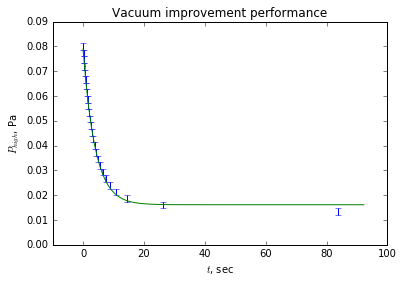

In [4]:
e = "performance-improve"

plt.title("Vacuum improvement performance")
plt.xlabel("$t$, sec")
plt.ylabel("$P_{high}$, Pa")

plt.errorbar(x = columns[e].t,
             xerr = columns[e].Error_t,
             y = columns[e].P_h,
             yerr = columns[e].Error_P_h,
             linestyle = "none")

model = ll.fit2(name = "P_h",
                model = lambda t, _P_0, _W_V, _P_best: _P_0 * ll.exp(-t * _W_V) + _P_best,
                data = data[e],
                x = columns[e].t,
                xerr = columns[e].Error_t,
                y = columns[e].P_h,
                yerr = columns[e].Error_P_h)

t_linspace = ll.linspace(columns[e].t)

plt.errorbar(x = t_linspace,
             y = model(t_linspace))

plt.axis([-10, None, 0, None])
plt.plot()

In [5]:
e = "performance-improve"

ll.compute(name = "W",
           expr = lambda _W_V, V_high: _W_V * V_high,
           data = data[e],
           debug = True)

for e2 in experiments:
    ll.add(data[e2], data[e].loc[["W"]])

Computing variable W
Error influence estimations:


,Error,Derivative,(E*D)^2
V_high,0.000336,0.252422701424140,7.20156018212519e-9
_W_V,0.005853,0.00192034647342142,1.26317299881345e-10


Result:


,Value,Error,ErrorRel
W,0.000485,0.000086,17.66%


Оценим обратный поток газа через диффузионный насос, исходя из временных характеристик ухудшения вакуума и уже вычисленной производительности насоса.

Initial guesses for P_h:
            Value    Error  ErrorRel
_dP_dT  0.000890 0.000012  0.013100
_P_best 0.016543 0.000473  0.028613


'Final guesses for P_h:'

,Value,Error,ErrorRel
_dP_dT,0.000890,0.000011,1.28%
_P_best,0.016543,0.000461,2.79%


[]

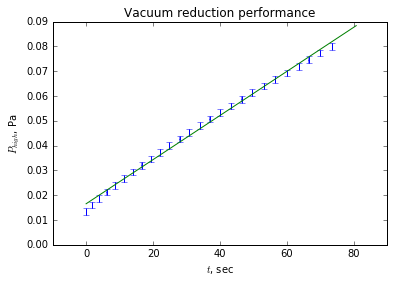

In [6]:
e = "performance-fall"

plt.title("Vacuum reduction performance")
plt.xlabel("$t$, sec")
plt.ylabel("$P_{high}$, Pa")

plt.errorbar(x = columns[e].t,
             xerr = columns[e].Error_t,
             y = columns[e].P_h,
             yerr = columns[e].Error_P_h,
             linestyle = "none")

model = ll.fit2(name = "P_h",
                model = lambda t, _dP_dT, _P_best: _P_best + t * _dP_dT, 
                data = data[e],
                x = columns[e].t,
                xerr = columns[e].Error_t,
                y = columns[e].P_h,
                yerr = columns[e].Error_P_h)

t_linspace = ll.linspace(columns[e].t)

plt.errorbar(x = t_linspace,
             y = model(t_linspace))

plt.axis([-10, None, 0, None])
plt.plot()

In [7]:
e = "performance-fall"

ll.compute(name = "Q_p",
           expr = lambda _P_best, W, V_high, _dP_dT: _P_best*W - V_high*_dP_dT,
           data = data[e],
           debug = True)
[]

Computing variable Q_p
Error influence estimations:


,Error,Derivative,(E*D)^2
W,0.000086,0.0165426724150055,2.00534702962259e-12
V_high,0.000336,-0.000890300514790528,8.95865934726469e-14
_P_best,0.000461,0.000484739044491355,4.99978639814476e-14
_dP_dT,0.000011,-0.00192034647342142,4.76383617028347e-16


Result:


,Value,Error,ErrorRel
Q_p,0.000006,0.000001,23.22%


[]

Рассчитаем производительность диффузионного насоса во второй раз, теперь исходя из изменения давления при создании управляемой течи через капилляр.

In [8]:
e = "leak"

ll.compute(name = "W_l",
           expr = lambda d_cap, L_cap, T_ambient, mu_ambient, P_h_best, P_h_leak, P_f_leak:
                         4/3 * (d_cap/2)**3 * (2*m.pi*ll.R*T_ambient/mu_ambient)**(1/2) * (P_f_leak - P_h_leak)/(L_cap*(P_h_leak - P_h_best)),
           data = data[e],
           debug = True)
[]

Computing variable W_l
Error influence estimations:


,Error,Derivative,(E*D)^2
P_h_leak,0.001333,-0.167769623883560,5.00302770439657e-8
d_cap,0.000050,2.44547481106803,1.49508676289205e-8
P_f_leak,0.033331,0.00101903139851969,1.15361632939202e-9
P_h_best,0.000133,0.166750592485040,4.94243557980843e-10
mu_ambient,0.000050,-0.126490076434553,3.99993485910478e-11
T_ambient,5.000000,1.22273740553401e-6,3.73771690723013e-11
L_cap,0.000500,-0.0116451181479430,3.39021941698878e-11


Result:


,Value,Error,ErrorRel
W_l,0.000734,0.000258,35.21%


[]

[]

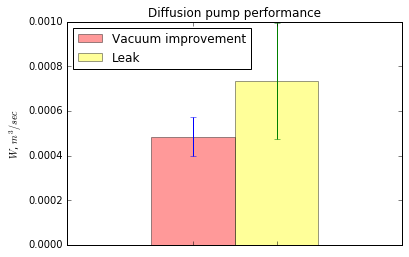

In [9]:
plt.title("Diffusion pump performance")
plt.ylabel("$W$, $m^3/sec$")

plt.bar(left = [0],
        width = 1,
        height = [data["performance-improve"].Value["W"]],
        yerr = [data["performance-improve"].Error["W"]],
        color = "red",
        alpha = 0.4,
        label = "Vacuum improvement")
plt.bar(left = [1],
        width = 1,
        height = [data["leak"].Value["W_l"]],
        yerr = [data["leak"].Error["W_l"]],
        color = "yellow",
        alpha = 0.4,
        label = "Leak")

plt.xticks([0.5, 1.5], [])
plt.legend(loc = "upper left")
plt.axis([-1, 3, None, None])
plt.plot()

Оцененное таким образом значение получилось выше, чем рассчитанное исходя из предельного вакуума. Это может быть следствием того, что нельзя полностью исключить вязкостные (межмолекулярные) эффекты в протекающем через капилляр газе, за счёт чего поток газа через капилляр наверняка меньше теоретического.